In [24]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torchviz import make_dot
import numpy as np
import shap
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 128
num_epochs = 20
learning_rate = 0.01
momentum=0.5
device = torch.device('cuda')

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        # 
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [7]:
model = Net()
model

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [26]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up batch loss
            test_loss += F.nll_loss(output.log(),
                                    target).item()  
            
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [27]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST(
    'mnist_data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST(
    'mnist_data',
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True)

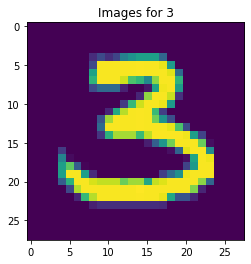

In [28]:
batch = next(iter(train_loader))
images, labels = batch
plt.imshow(images[:1][0][0].numpy());
plt.title(f'Images for {str(labels[:1][0].numpy())}');

In [15]:
# Instantiate the model and optimizer
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309032
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.268634
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.161892
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.491270
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.877707

Test set: Average loss: 0.0057, Accuracy: 8865/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.661684
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.640341
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.603985
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.488464
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.417882

Test set: Average loss: 0.0027, Accuracy: 9371/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.443567
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.498012
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.610534
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.410459
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.378239

Test set: Average loss: 0.0018, Accuracy: 9517/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.209855
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [29]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images.size()
torch.Size([128, 1, 28, 28])

torch.Size([128, 1, 28, 28])

In [31]:
background = images[:100]
e = shap.DeepExplainer(model.cuda(), background.cuda())
e

In [32]:
n_test_images = 10
test_images = images[100:100+n_test_images]
shap_values = e.shap_values(test_images)

In [33]:
# rehspae the shap value array and test image array for visualization 
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

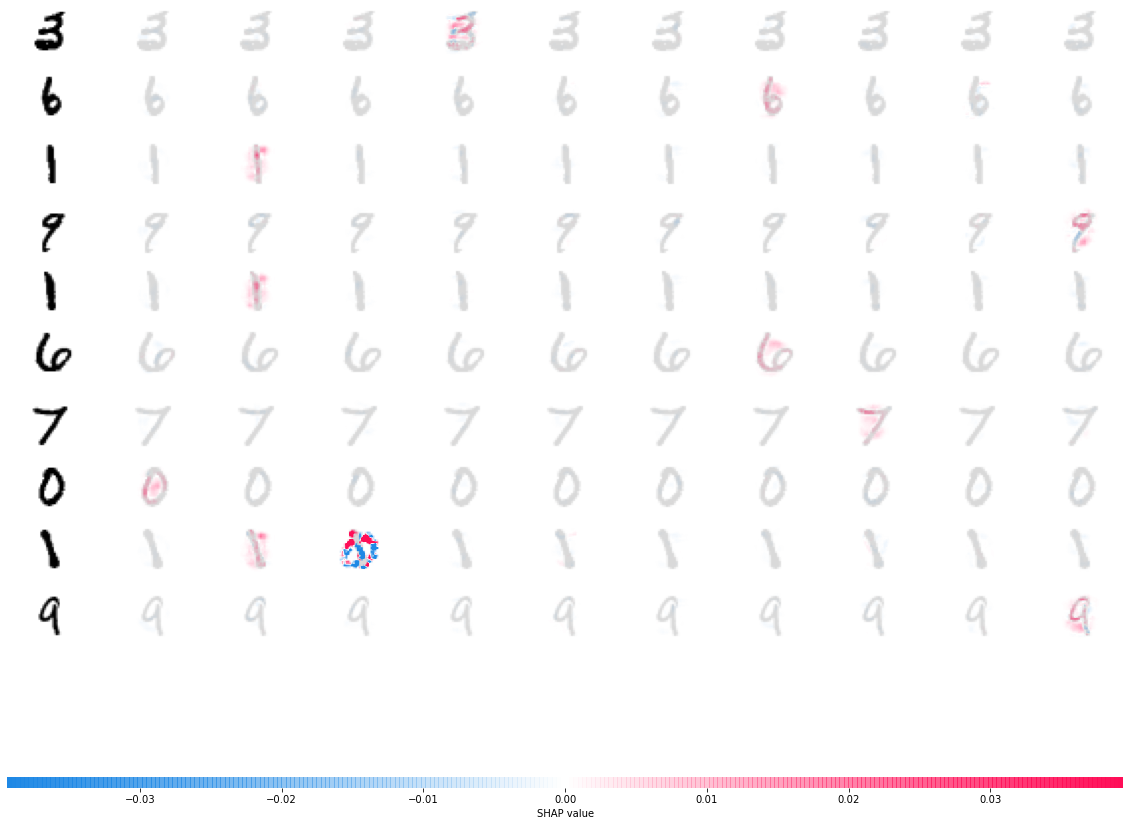

In [34]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)